# Import Libraries

In [2]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt

# Load the Datasets

In [8]:
train_df = pd.read_csv("../data/pre_train.csv", index_col=0)
val_df = pd.read_csv("../data/pre_val.csv", index_col=0)
test_df = pd.read_csv("../data/pre_test.csv", index_col=0)

## Data Windowing

The models will make a set of predictions based on a window of consecutive samples from the data.

So, we will create Dataset Class that will be responsible for splitting the data into windows.

We will make the dataset adapt to the type of model we want to train (multi-output or single-output) by changing the `label_columns` parameter.

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        label_column: str = "Temp",
        input_width: int = 1,
        output_width: int = 1,
        shift: int = 1,
    ):
        self.data_df = data
        self.data = data.to_numpy()
        self.input_width = input_width
        self.output_width = output_width
        self.shift = shift

        if label_column:
            self.label_column_idx = data.columns.get_loc(label_column)
        else:
            self.label_column_idx = slice(None)

    def __len__(self):
        return (
            self.data.shape[0] - (self.input_width + self.output_width + self.shift) + 1
        )

    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.input_width
        features = self.data[start_idx:end_idx]

        start_idx = end_idx + self.shift
        end_idx = start_idx + self.output_width
        labels = self.data[start_idx:end_idx, self.label_column_idx]
        return {"features": features, "labels": labels}

Create a function to plot the input features, label, and prediction over a batch.

In [11]:
def plot_windows(
    dataset: TimeSeriesDataset,
    features_batch: torch.tensor,
    labels_batch: torch.tensor,
    model: nn.Module = None,
    plot_column: str = "Temp",
    num_samples: int = 1,
):
    """Plot the features, Labels and predictions for a single batch created by the dataloader"""
    _, axes = plt.subplots(
        nrows=num_samples,
        ncols=1,
        figsize=(14, 5 * num_samples),
        sharex=True,
        sharey=True,
    )
    plot_col_index = dataset.data_df.columns.get_loc(plot_column)

    for i, ax in enumerate(np.array(axes).reshape(-1)):
        features = features_batch[i, ...].numpy()
        labels = labels_batch[i, ...].numpy()
        if model:
            preds = model(features)

        # Plotting the features labels
        ax.plot(
            range(dataset.input_width),
            features[:, plot_col_index],
            label="Input Feature Labels",
            marker=".",
        )
        # Plotting the true labels
        ax.scatter(
            range(
                dataset.input_width + dataset.shift,
                dataset.input_width + dataset.shift + dataset.output_width,
            ),
            labels,
            label="True Labels",
            marker="o",
            c="green",
        )
        if model:
            # Plotting the predicted labels
            ax.scatter(
                range(
                    dataset.input_width + dataset.shift,
                    dataset.input_width + dataset.shift + dataset.output_width,
                ),
                preds,
                label="Predictions",
                marker="x",
                color="orange",
            )
    plt.legend(loc="upper left")
    plt.show()

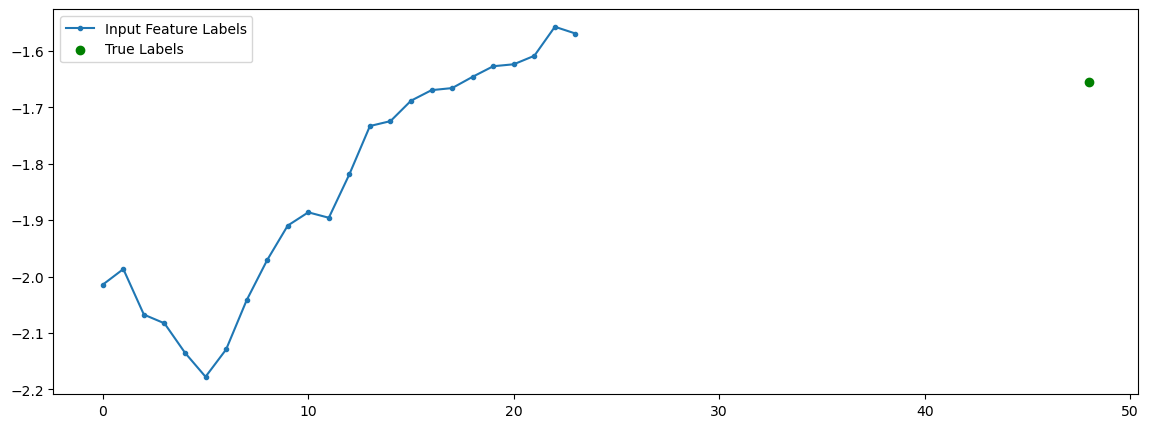

In [12]:
# Try to plot the first batch of the training data
train_dataset = TimeSeriesDataset(
    train_df, input_width=24, output_width=1, shift=24, label_column="Temp"
)
train_dataloader = DataLoader(train_dataset, batch_size=2)

for batch in train_dataloader:
    features = batch["features"]
    labels = batch["labels"]
    plot_windows(train_dataset, features, labels)
    break

## Models Architecture

### Baseline

We will use a simple Linear model as a baseline.

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

### Single Step Model